In [1]:
import os
from pathlib import Path
import sys
sys.path.insert(0,'../')
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
from doe_xstock.database import SQLiteDatabase
from doe_xstock.doe_xstock import DOEXStockDatabase
from doe_xstock.exploration import MetadataClustering

In [2]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
DATABASE_FILEPATH = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/database.db')
FIGURES_DIRECTORY = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/figures')
DATABASE = SQLiteDatabase(DATABASE_FILEPATH)

### Distribution of temperature difference between as-is model and simulation id 0

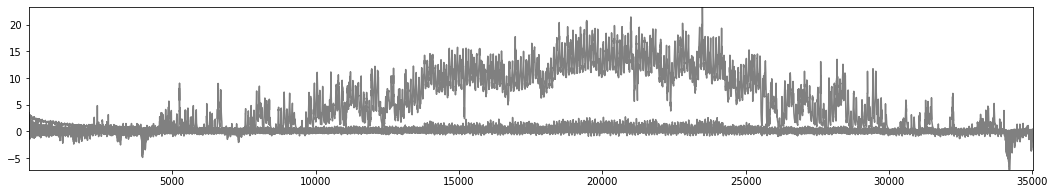

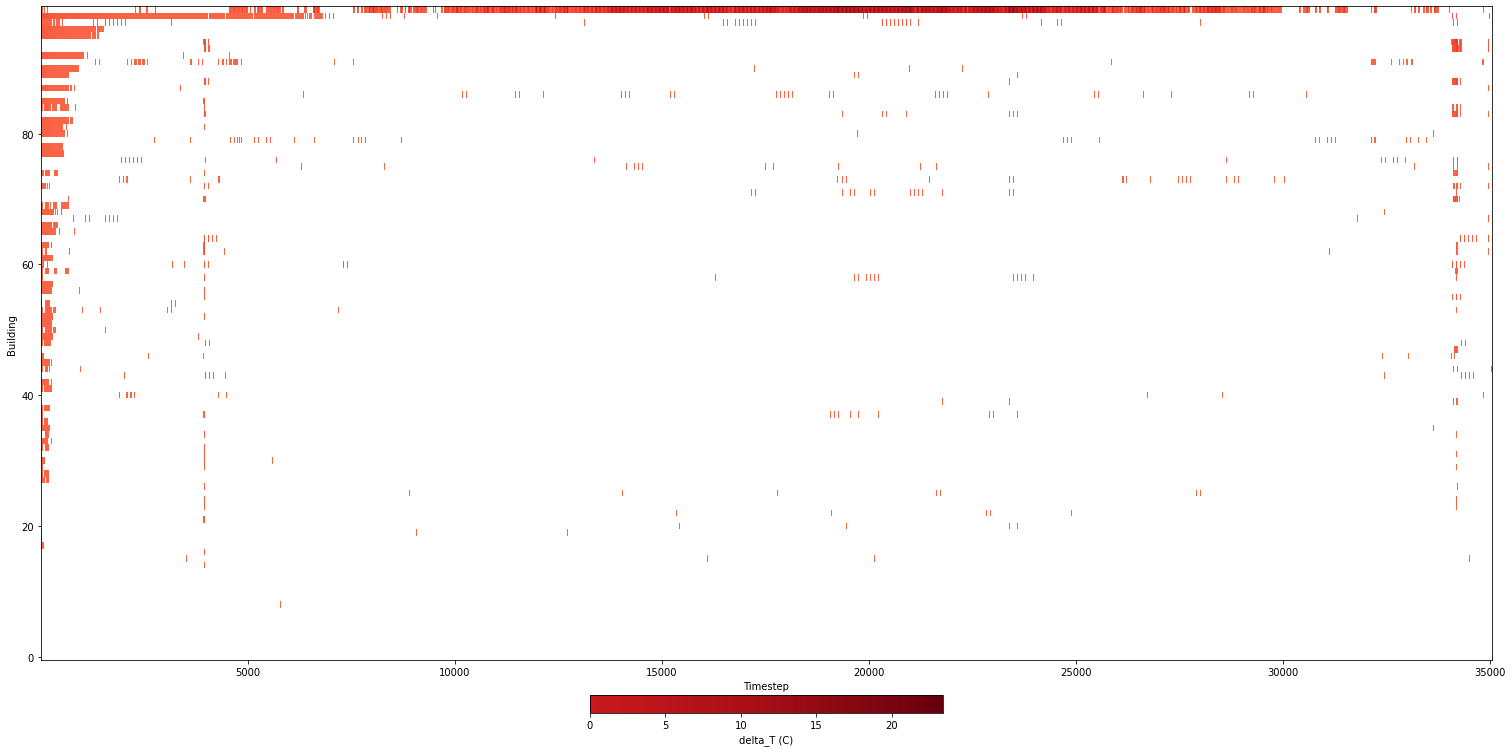

In [5]:
difference_data = DATABASE.query_table("""
SELECT
    t.timestep,
    t.metadata_id,
    t.value - s.average_indoor_air_temperature AS value
FROM weighted_average_zone_air_temperature t
LEFT JOIN lstm_train_data s ON 
    s.timestep = t.timestep
    AND s.metadata_id = t.metadata_id
WHERE s.simulation_id = 0
""")

# line plot
plot_data = difference_data.pivot(index='timestep',columns='metadata_id',values='value')
fig, ax = plt.subplots(1,1,figsize=(18,3))
x, y = plot_data.index, plot_data.values
ax.plot(x,y,color='grey')
plt.show()

# heat map of absolute difference centered at some threshold
limit = 0.5
plot_data = difference_data.copy()
plot_data['value'] = plot_data['value'].abs()
plot_data.loc[plot_data['value'] < limit,'value'] = None
plot_data = plot_data.pivot(index='metadata_id',columns='timestep',values='value')

# y ordering
y_order = plot_data.sum(axis=1).sort_values()
y_order = pd.DataFrame(y_order)
y_order['order'] = y_order.reset_index().index
plot_data = plot_data.merge(y_order[['order']],how='left',left_index=True,right_index=True)
plot_data = plot_data.sort_values('order').drop(columns=['order'])

plot_data = plot_data.reset_index(drop=True)
x, y, z = plot_data.columns.tolist(), plot_data.index.tolist(), plot_data.values
cmap = 'Reds'
norm = colors.TwoSlopeNorm(vcenter=0)
fig, ax = plt.subplots(1,1,figsize=(26,13))
pcm = ax.pcolormesh(x,y,z,shading='nearest',norm=norm,cmap=cmap,edgecolors='black',linewidth=0)
_ = fig.colorbar(pcm,ax=ax,orientation='horizontal',label='delta_T (C)',fraction=0.025,pad=0.05)
ax.tick_params('x',which='both',rotation=0)
# ax.set_yticks([])
ax.set_xlabel('Timestep')
ax.set_ylabel('Building')
plt.show()

### Temperature variance in partial load iterations

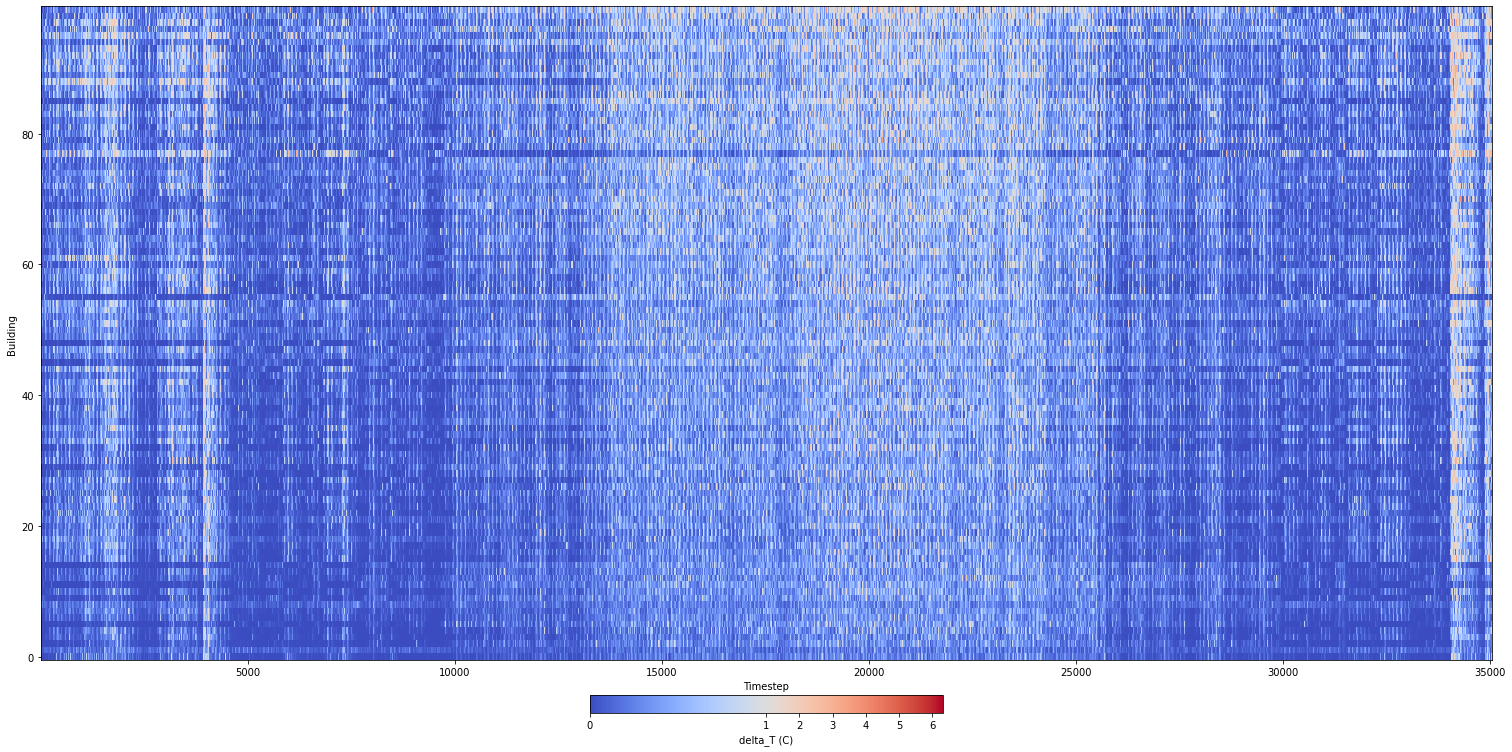

In [6]:
limit = 1.0
query = f"""
SELECT
    s.timestep,
    s.metadata_id,
    s.average_indoor_air_temperature - a.value AS value
FROM lstm_train_data s
LEFT JOIN (
    SELECT
        timestep,
        metadata_id,
        average_indoor_air_temperature AS value
    FROM lstm_train_data
    WHERE simulation_id = 0
) a ON
    s.timestep = a.timestep
    AND s.metadata_id = a.metadata_id
WHERE s.simulation_id != 0
"""
plot_data = DATABASE.query_table(query)
plot_data = plot_data.groupby(['metadata_id','timestep'])[['value']].std().reset_index()
plot_data = plot_data.pivot(index='metadata_id',columns='timestep',values='value')

# y ordering
y_order = plot_data.sum(axis=limit).sort_values()
y_order = pd.DataFrame(y_order)
y_order['order'] = y_order.reset_index().index
plot_data = plot_data.merge(y_order[['order']],how='left',left_index=True,right_index=True)
plot_data = plot_data.sort_values('order').drop(columns=['order'])

plot_data = plot_data.reset_index(drop=True)
x, y, z = plot_data.columns.tolist(), plot_data.index.tolist(), plot_data.values
cmap = 'coolwarm'
norm = colors.TwoSlopeNorm(vcenter=limit)
fig, ax = plt.subplots(1,1,figsize=(26,13))
pcm = ax.pcolormesh(x,y,z,shading='nearest',norm=norm,cmap=cmap,edgecolors='black',linewidth=0)
_ = fig.colorbar(pcm,ax=ax,orientation='horizontal',label='delta_T (C)',fraction=0.025,pad=0.05)
ax.tick_params('x',which='both',rotation=0)
ax.set_xlabel('Timestep')
ax.set_ylabel('Building')
plt.show()

In [31]:
metadata_ids = DATABASE.query_table('SELECT DISTINCT metadata_id FROM lstm_train_data')['metadata_id'].tolist()
color_list = ['red','green','blue','violet']
directory = os.path.join(FIGURES_DIRECTORY,'simulation_average_indoor_air_temperature_distribution')
os.makedirs(directory,exist_ok=True)

for metadata_id in metadata_ids:
    data = DATABASE.query_table(f"""
    SELECT
        m.in_resstock_county_id AS county,
        s.timestep,
        s.month,
        s.simulation_id,
        s.average_indoor_air_temperature AS value
    FROM lstm_train_data s
    LEFT JOIN metadata m ON m.id = s.metadata_id
    WHERE s.metadata_id = {metadata_id}
    """)
    months = data['month'].unique()
    row_count = len(months)
    column_count = 1
    fig, ax = plt.subplots(row_count,column_count,figsize=(18*column_count,2.5*row_count))

    for ax, ((county, month), plot_data) in zip(fig.axes, data.groupby(['county','month'])): 
        plot_data = plot_data.pivot_table(index='timestep',columns='simulation_id',values='value')
    
        for column, color in zip(plot_data.columns, color_list):
            x, y = plot_data.index, plot_data[column]
            ax.scatter(x,y,color=color,s=5,label=column)
            ax.set_title(month)

        ax.set_xlabel('Timestep')
        ax.set_ylabel('C')
        ax.legend()

    plt.tight_layout()
    filename = f'{county.lower().replace(" ","_").replace(",","")}-{metadata_id}.png'
    filepath = os.path.join(directory,filename)
    plt.savefig(filepath,facecolor='white',bbox_inches='tight')
    plt.close()